In [1]:
from sqlalchemy import create_engine,text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
db_user = ""
db_password = ""
db_host = "" 
db_port = ""  
db_name = ""

In [3]:
connection = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(connection)

In [4]:
query= text(r"SELECT DATE(datefrom) AS date, (regexp_split_to_array(layerid, '\|'))[2]  AS PRO_FROM, (regexp_split_to_array(toid, '\|'))[2]  AS PRO_TO, SUM(datavalue) AS datavalue, SUM(Ni) AS ni, SUM(Ns) AS ns, SUM(Tb) AS tb, SUM(Tc) AS tc, SUM(Gm) AS gm, SUM(Gf) AS gf, SUM(F1) AS f1, SUM(F2) AS f2, SUM(F3) AS f3, SUM(F4) AS f4, SUM(F5) AS f5, SUM(F6) AS f6  FROM movements  GROUP BY date, PRO_FROM, PRO_TO  ORDER BY date;")
try:
    with engine.connect() as connection:
        chunks = pd.read_sql(query, connection, chunksize=1000) 
        df = pd.concat(chunks, ignore_index=True) 
    print(df)
except Exception as e:
    print(f"Errore durante l'esecuzione della query: {e}")

            date pro_from pro_to  datavalue      ni     ns     tb      tc  \
0     2019-08-01      033    033     367422  330751  36671  46058  321364   
1     2019-08-01      033    034      29272   26507   2765   3327   25945   
2     2019-08-01      033    035       4613    4292    321    652    3961   
3     2019-08-01      033    036       3103    2894    209    473    2630   
4     2019-08-01      033    037       5061    4770    291    883    4178   
...          ...      ...    ...        ...     ...    ...    ...     ...   
4936  2019-09-30      099    037       8017    7971     46    386    7631   
4937  2019-09-30      099    038        531     531      0      9     522   
4938  2019-09-30      099    039       7401    7341     60    527    6874   
4939  2019-09-30      099    040      55041   54279    762   5138   49903   
4940  2019-09-30      099    099     487497  474989  12508  56088  431409   

          gm      gf    f1     f2     f3      f4      f5      f6  
0     20

In [5]:
from sklearn.preprocessing import LabelEncoder
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df["date"] = df['date'].astype('int64')
label_encoder = LabelEncoder()
df['pro_from'] = label_encoder.fit_transform(df['pro_from'])
df['pro_to'] = label_encoder.fit_transform(df['pro_to'])
df

,date,pro_from,pro_to,datavalue,ni,ns,tb,tc,gm,gf,f1,f2,f3,f4,f5,f6
0,1564617600000000000,0,0,367422,330751,36671,46058,321364,204409,163013,2929,37099,40234,79731,85347,122082
1,1564617600000000000,0,1,29272,26507,2765,3327,25945,17387,11885,44,2273,2642,7301,7437,9575
2,1564617600000000000,0,2,4613,4292,321,652,3961,2835,1778,1,263,288,1269,1275,1517
3,1564617600000000000,0,3,3103,2894,209,473,2630,1927,1176,0,167,181,861,868,1026
4,1564617600000000000,0,4,5061,4770,291,883,4178,3154,1907,1,246,255,1439,1444,1676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4936,1569801600000000000,8,4,8017,7971,46,386,7631,4971,3046,0,368,372,2302,2306,2669
4937,1569801600000000000,8,5,531,531,0,9,522,346,185,0,9,9,168,168,177
4938,1569801600000000000,8,6,7401,7341,60,527,6874,4436,2965,4,474,524,2003,1987,2409
4939,1569801600000000000,8,7,55041,54279,762,5138,49903,31361,23680,382,5025,5989,13488,13104,17053


Target: Nazionalità

In [7]:
target=['ni','ns']
X = df.drop(['datavalue','ni','ns','tb','tc','gm','gf','f1','f2','f3','f4','f5','f6'],axis='columns')
y = df[target]

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Random Forest

*** Random Forest ***
MAE ni: 16206.0491
MAPE ni: 46.5877%
MSE ni: 1684623644.9547
R^2 ni: 0.9409
MAE ns: 1065.1425
MAPE ns: -%
MSE ns: 12213400.2147
R^2 ns: 0.9221


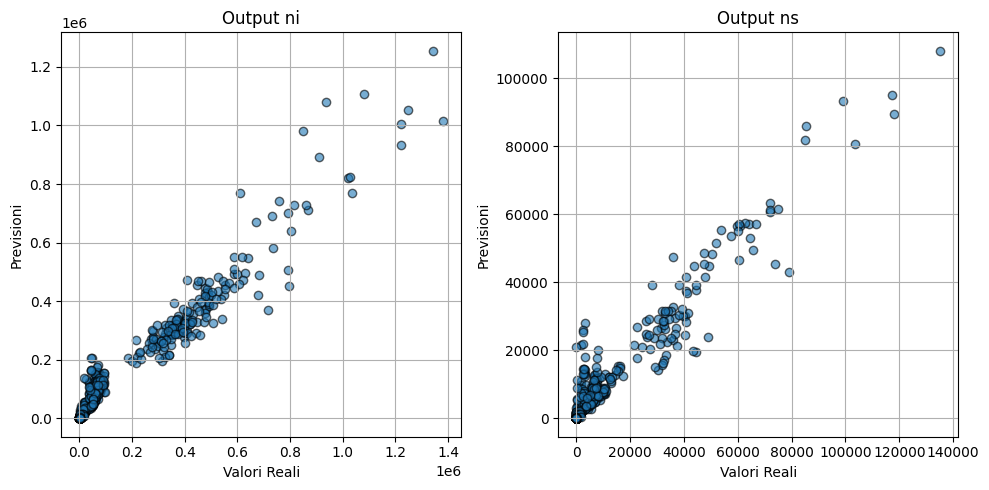

In [10]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,mean_squared_error,r2_score
from sklearn.multioutput import MultiOutputRegressor 

Model_RF = MultiOutputRegressor(RandomForestRegressor())
Model_RF.fit(X_train, y_train)  
y_pred_RF = Model_RF.predict(X_test) 

print("*** Random Forest ***")

for i in range(len(target)):
    mae = mean_absolute_error(y_test.iloc[:,i], y_pred_RF[:,i])
    print(f"MAE {target[i]}: {mae:.4f}")
    mape = mean_absolute_percentage_error(y_test.iloc[:,i], y_pred_RF[:,i])*100
    if y_test.iloc[:,i].min()==0 :
        print(f"MAPE {target[i]}: -%")
    else:    
        print(f"MAPE {target[i]}: {mape:.4f}%")
    mse=mean_squared_error(y_test.iloc[:,i], y_pred_RF[:,i])
    print(f"MSE {target[i]}: {mse:.4f}")
    r2=r2_score(y_test.iloc[:,i], y_pred_RF[:,i])
    print(f"R^2 {target[i]}: {r2:.4f}")
fig, axes = plt.subplots(1, len(target), figsize=(5 *len(target) , 5))

for i, ax in enumerate(axes):
    ax.scatter(y_test.iloc[:, i], y_pred_RF[:, i], alpha=0.6, edgecolors="k")
    ax.set_title(f"Output {target[i]}")
    ax.set_xlabel("Valori Reali")
    ax.set_ylabel("Previsioni")
    ax.grid(True)
plt.tight_layout()
plt.show()

K-Nearest Neighbors

In [12]:
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

y_train_scaled_KNN = np.log1p(y_train)
y_test_scaled_KNN = np.log1p(y_test)
scaler = MinMaxScaler()
X_train_scaled_KNN = scaler.fit_transform(X_train)
X_test_scaled_KNN = scaler.transform(X_test)

param_grid = {
    'n_neighbors': range(2, 50),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_scaled_KNN, y_train_scaled_KNN)
best_params = grid_search.best_params_
print("Migliori parametri:", best_params)

Migliori parametri: {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}


*** K-Nearest Neighbors ***
MAE ni: 5437.0408
MAPE ni: 15.3600%
MSE ni: 533892397.9481
R^2 ni: 0.9813
MAE ns: 498.6085
MAPE ns: -%
MSE ns: 6238764.2355
R^2 ns: 0.9602


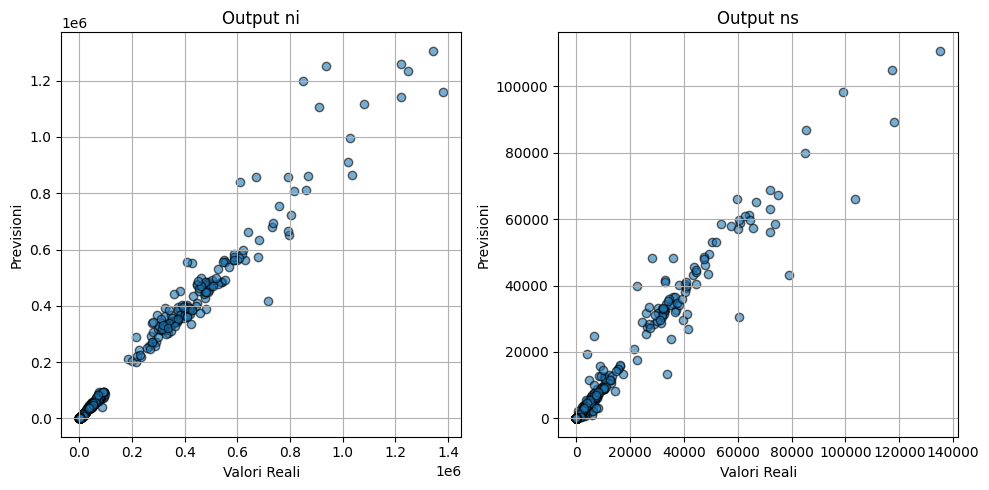

In [13]:
print("*** K-Nearest Neighbors ***")
Model_KNN = KNeighborsRegressor(
    n_neighbors= best_params['n_neighbors'],
    weights=best_params['weights'],
    metric=best_params['metric']
)

Model_KNN.fit(X_train_scaled_KNN, y_train_scaled_KNN)
y_pred_KNN = Model_KNN.predict(X_test_scaled_KNN)

y_pred_KNN = np.expm1(y_pred_KNN)
y_test = np.expm1(y_test_scaled_KNN)

for i in range(len(target)):
    mae = mean_absolute_error(y_test.iloc[:,i], y_pred_KNN[:,i])
    print(f"MAE {target[i]}: {mae:.4f}")
    mape = mean_absolute_percentage_error(y_test.iloc[:,i], y_pred_KNN[:,i])*100
    if y_test.iloc[:,i].min()==0 :
        print(f"MAPE {target[i]}: -%")
    else:    
        print(f"MAPE {target[i]}: {mape:.4f}%")
    mse=mean_squared_error(y_test.iloc[:,i], y_pred_KNN[:,i])
    print(f"MSE {target[i]}: {mse:.4f}")
    r2=r2_score(y_test.iloc[:,i], y_pred_KNN[:,i])
    print(f"R^2 {target[i]}: {r2:.4f}")
fig, axes = plt.subplots(1, len(target), figsize=(5 *len(target) , 5))

for i, ax in enumerate(axes):
    ax.scatter(y_test.iloc[:, i], y_pred_KNN[:, i], alpha=0.6, edgecolors="k")
    ax.set_title(f"Output {target[i]}")
    ax.set_xlabel("Valori Reali")
    ax.set_ylabel("Previsioni")
    ax.grid(True)
plt.tight_layout()
plt.show()

Gradient Boosting

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

y_train_scaled_GB = np.log1p(y_train)
y_test_scaled_GB = np.log1p(y_test)
scaler = MinMaxScaler()
X_train_scaled_GB = scaler.fit_transform(X_train)
X_test_scaled_GB = scaler.transform(X_test)

param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__learning_rate': [0.01, 0.05, 0.1],
    'estimator__max_depth': [3, 4, 5]
}

base_model = GradientBoostingRegressor()
multi_output_model = MultiOutputRegressor(base_model)

grid_search = GridSearchCV(multi_output_model, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_scaled_GB, y_train_scaled_GB)
best_model = grid_search.best_estimator_

*** Gradient Boosting ***
MAE ni: 8265.4493
MAPE ni: 13.5024%
MSE ni: 810667504.3371
R^2 ni: 0.9715
MAE ns: 934.9662
MAPE ns: -%
MSE ns: 14997470.4996
R^2 ns: 0.9043


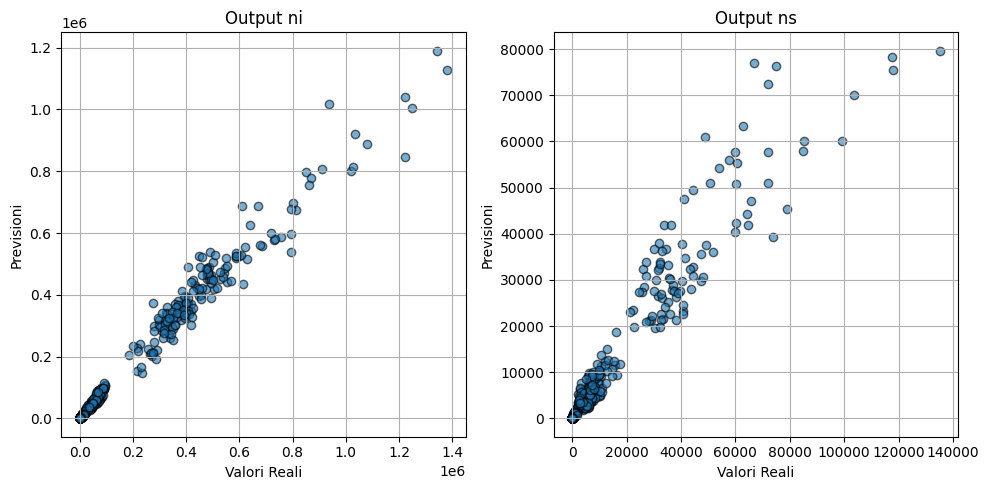

In [16]:
print("*** Gradient Boosting ***")
y_pred_GB = best_model.predict(X_test_scaled_GB)

y_pred_GB = np.expm1(y_pred_GB)
y_test = np.expm1(y_test_scaled_GB)

for i in range(len(target)):
    mae = mean_absolute_error(y_test.iloc[:,i], y_pred_GB[:,i])
    print(f"MAE {target[i]}: {mae:.4f}")
    mape = mean_absolute_percentage_error(y_test.iloc[:,i], y_pred_GB[:,i])*100
    if y_test.iloc[:,i].min()==0 :
        print(f"MAPE {target[i]}: -%")
    else:    
        print(f"MAPE {target[i]}: {mape:.4f}%")
    mse=mean_squared_error(y_test.iloc[:,i], y_pred_GB[:,i])
    print(f"MSE {target[i]}: {mse:.4f}")
    r2=r2_score(y_test.iloc[:,i], y_pred_GB[:,i])
    print(f"R^2 {target[i]}: {r2:.4f}")
fig, axes = plt.subplots(1, len(target), figsize=(5 *len(target) , 5))

for i, ax in enumerate(axes):
    ax.scatter(y_test.iloc[:, i], y_pred_GB[:, i], alpha=0.6, edgecolors="k")
    ax.set_title(f"Output {target[i]}")
    ax.set_xlabel("Valori Reali")
    ax.set_ylabel("Previsioni")
    ax.grid(True)
plt.tight_layout()
plt.show()